## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

## Arguments & Initializations

In [5]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [6]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [7]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [8]:
DATASET = "bank"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [9]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [10]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

In [11]:
dataset_orig.features.shape

(25836, 57)

In [12]:
privileged_groups

[{'age': 1}]

In [13]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[  1.  68.   1. ...   0.   1.   0.]
 [  1. 217.   9. ...   0.   1.   0.]
 [  1. 517.   1. ...   0.   1.   0.]
 ...
 [  1.  34.   3. ...   0.   1.   0.]
 [  1. 118.   3. ...   0.   1.   0.]
 [  1. 878.   3. ...   0.   1.   0.]]


In [14]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [15]:
dataset_orig_train

               instance weights            features                           \
                                protected attribute                            
                                                age duration campaign  pdays   
instance names                                                                 
35529                       1.0                 1.0     68.0      1.0  999.0   
14902                       1.0                 1.0    217.0      9.0  999.0   
26786                       1.0                 1.0    517.0      1.0  999.0   
26655                       1.0                 1.0    277.0      1.0  999.0   
31275                       1.0                 1.0    457.0      1.0  999.0   
...                         ...                 ...      ...      ...    ...   
13972                       1.0                 1.0    252.0      2.0  999.0   
4048                        1.0                 1.0    105.0      1.0  999.0   
5828                        1.0         

In [16]:
dataset_orig_train?

## Run Mitigating Algorithms

In [17]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    train_test_egr, egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[  1. 156.   1. ...   0.   1.   0.]
 [  1. 292.   2. ...   0.   1.   0.]
 [  1. 212.   1. ...   0.   1.   0.]
 ...
 [  1. 241.   2. ...   0.   1.   0.]
 [  1. 219.   1. ...   0.   1.   0.]
 [  1. 453.   2. ...   0.   1.   0.]]
no bias type specified
#### Training Dataset shape
(12918, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=student', 'job=technician', 'job=unemployed', 'marital=divorced', 'marital=married', 'marital=single', 'educatio

Number of training samples (ntrain): 11153
Number of test samples (ntest): 11218
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1163
Number of test samples (ntest): 1114
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -0.5555258026838976
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11603, Test = 11661
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.5520685823000399
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1315, Test = 1257
  AUC: 0.65
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.40


Number of training samples (ntrain): 11153
Number of test samples (ntest): 11218
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1163
Number of test samples (ntest): 1114
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.5908683314395271
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11603, Test = 11661
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.2623642644674911
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1315, Test = 1257
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.51
  Test Accuracy (TNR): 0.65


Number of training samples (ntrain): 11153
Number of test samples (ntest): 11218
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1163
Number of test samples (ntest): 1114
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.07
  Positive predictive value: 0.53
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11603, Test = 11661
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1315, Test = 1257
  AUC: 0.66
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR):

Number of training samples (ntrain): 11153
Number of test samples (ntest): 11218
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1163
Number of test samples (ntest): 1114
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.6288825940406507
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11603, Test = 11661
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.6288825940406507
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1315, Test = 1257
  AUC: 0.64
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.56


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.0911131754141508
Balanced accuracy is:  0.3397063913143766
Accuracy for threshold: 0.02  is: 0.0911131754141508
Balanced accuracy is:  0.3397063913143766
Accuracy for threshold: 0.03  is: 0.0911131754141508
Balanced accuracy is:  0.3397063913143766
Accuracy for threshold: 0.04  is: 0.09420962997368014
Balanced accuracy is:  0.2629898245155148
Accuracy for threshold: 0.05  is: 0.09420962997368014
Balanced accuracy is:  0.2629898245155148
Accuracy for threshold: 0.060000000000000005  is: 0.09420962997368014
Balanced accuracy is:  0.2629898245155148
Accuracy for threshold: 0.06999999999999999  is: 0.09420962997368014
Balanced accuracy is:  0.2629898245155148
Accuracy for threshold: 0.08  is: 0.09420962997368014
Balanced accuracy is:  0.2629898245155148
Accuracy for threshold: 0.09  is: 0.09420962997368014
Balanced accuracy is:  0.2629898245155148
Accuracy for threshold: 0.09999999999999999  is: 0.09420962997368014
Balanced accuracy is:  0.2

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. U

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99       450
         1.0       0.00      0.00      0.00         0

    accuracy                           0.97       450
   macro avg       0.50      0.49      0.49       450
weighted avg       1.00      0.97      0.99       450

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.74      0.85       152

    accuracy                           0.74       152
   macro avg       0.50      0.37      0.42       152
weighted avg       1.00      0.74      0.85       152

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     11153
         1.0       0.00      0.00      0.00         0

    accuracy                           0.98     11153
   macro avg       0.50   

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 450
Number of test samples (ntest): 443
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 152
Number of test samples (ntest): 143
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 11153
Number of test samples (ntest): 11218
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1163
Number of test samples (ntest): 1114
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11603, Test = 11661
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.04
  Positive predi

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


Best balanced accuracy: 0.5283
Corresponding 1-min(DI, 1/DI) value: 0.0000
Corresponding average odds difference value: 0.3586
Corresponding statistical parity difference value: 0.2594
Corresponding equal opportunity difference value: 0.5524
Corresponding Theil index value: 0.0980
Corresponding false positive_rate for privileged: 0.0000
Corresponding false negative_rate for privileged: 1.0000
Corresponding false positive_rate for unpribileged: 0.1648
Corresponding false negative_rate for unprivileged: 0.4476
#### Train dataset's features are as below:
[[  1. 101.   5. ...   0.   1.   0.]
 [  0. 178.   2. ...   0.   1.   0.]
 [  1. 417.   3. ...   0.   1.   0.]
 ...
 [  1. 359.   5. ...   0.   1.   0.]
 [  1. 207.   1. ...   0.   1.   0.]
 [  1. 453.   1. ...   0.   1.   0.]]
no bias type specified
#### Training Dataset shape
(12918, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'

Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -0.7006943861953283
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.6931471805599453
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1277, Test = 1295
  AUC: 0.66
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.52


Accuracy for threshold: 0.5  is: 0.9077256541260257
Balanced accuracy is:  0.7082217158961546
True positive rate is:  0.4586872586872587
True negative rate is:  0.9577561731050503
Balanced accuracy is:  0.7082217158961546
Test Accuracy is:  0.9077256541260257
Best balanced accuracy: 0.7082
Corresponding 1-min(DI, 1/DI) value: 0.6479
Corresponding average odds difference value: -0.1042
Corresponding statistical parity difference value: 0.0445
Corresponding equal opportunity difference value: -0.2605
Corresponding Theil index value: 0.0700
Corresponding false positive_rate for privileged: 0.0403
Corresponding false negative_rate for privileged: 0.5113
Corresponding false positive_rate for unpribileged: 0.0923
Corresponding false negative_rate for unprivileged: 0.7718
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 449
Number of test samples (ntest): 444
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 146
Number of test samples (ntest): 149


Accuracy for threshold: 0.48000000000000004  is: 0.9010682768230376
Balanced accuracy is:  0.7172161972815849
Accuracy for threshold: 0.49  is: 0.9010682768230376
Balanced accuracy is:  0.7172161972815849
Accuracy for threshold: 0.5  is: 0.9013779222789906
Balanced accuracy is:  0.7105266252474374
Best thresh:  0.08
Best balanced accuracy: 0.7105
Corresponding 1-min(DI, 1/DI) value: 0.3676
Corresponding average odds difference value: 0.0454
Corresponding statistical parity difference value: 0.1482
Corresponding equal opportunity difference value: -0.0250
Corresponding Theil index value: 0.0711
Corresponding false positive_rate for privileged: 0.0463
Corresponding false negative_rate for privileged: 0.5253
Corresponding false positive_rate for unpribileged: 0.1622
Corresponding false negative_rate for unprivileged: 0.5503
Testing Original ...
Accuracy for threshold: 0.08  is: 0.8576405016256387
Balanced accuracy is:  0.814191041129009
True positive rate is:  0.7598455598455598
True nega

Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -0.6577596562482995
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.6577596562482995
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1277, Test = 1295
  AUC: 0.67
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.51


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.02  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.03  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.04  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.05  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.060000000000000005  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.06999999999999999  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.08  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.09  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.09999999999999999  is: 0.0915776435980802
Balanced accuracy is:  0.3404

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99       449
         1.0       0.00      0.00      0.00         0

    accuracy                           0.97       449
   macro avg       0.50      0.49      0.49       449
weighted avg       1.00      0.97      0.99       449

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80       146

    accuracy                           0.67       146
   macro avg       0.50      0.34      0.40       146
weighted avg       1.00      0.67      0.80       146

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     11192
         1.0       0.00      0.00      0.00         0

    accuracy                           0.98     11192
   macro avg       0.50   

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 449
Number of test samples (ntest): 444
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 146
Number of test samples (ntest): 149
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -0.04984180047957301
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.03
  Positive predict

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


Best balanced accuracy: 0.5184
Corresponding 1-min(DI, 1/DI) value: 0.0000
Corresponding average odds difference value: 0.2454
Corresponding statistical parity difference value: 0.1872
Corresponding equal opportunity difference value: 0.3624
Corresponding Theil index value: 0.1029
Corresponding false positive_rate for privileged: 0.0000
Corresponding false negative_rate for privileged: 1.0000
Corresponding false positive_rate for unpribileged: 0.1284
Corresponding false negative_rate for unprivileged: 0.6376
#### Train dataset's features are as below:
[[  1. 101.   5. ...   0.   1.   0.]
 [  0. 178.   2. ...   0.   1.   0.]
 [  1. 417.   3. ...   0.   1.   0.]
 ...
 [  1. 359.   5. ...   0.   1.   0.]
 [  1. 207.   1. ...   0.   1.   0.]
 [  1. 453.   1. ...   0.   1.   0.]]
no bias type specified
#### Training Dataset shape
(12918, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'

Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -0.7006943861953283
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.6931471805599453
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1277, Test = 1295
  AUC: 0.66
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.52


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 449
Number of test samples (ntest): 444
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 146
Number of test samples (ntest): 149
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.7472144018302211
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.02
  Positive predicti

Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -1.0608719606852628
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -1.0116009116784799
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1277, Test = 1295
  AUC: 0.65
  Privacy Risk: 0.62
  Accuracy: 0.61
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.36


Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 146
Number of test samples (ntest): 149
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -0.6577596562482995
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.6577596562482995
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.02  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.03  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.04  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.05  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.060000000000000005  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.06999999999999999  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.08  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.09  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.09999999999999999  is: 0.0915776435980802
Balanced accuracy is:  0.3404

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99       449
         1.0       0.00      0.00      0.00         0

    accuracy                           0.97       449
   macro avg       0.50      0.49      0.49       449
weighted avg       1.00      0.97      0.99       449

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80       146

    accuracy                           0.67       146
   macro avg       0.50      0.34      0.40       146
weighted avg       1.00      0.67      0.80       146

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     11192
         1.0       0.00      0.00      0.00         0

    accuracy                           0.98     11192
   macro avg       0.50   

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


In [18]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()

In [19]:
df_bank['age'].value_counts()

age
1.0    24648
0.0     1188
Name: count, dtype: int64

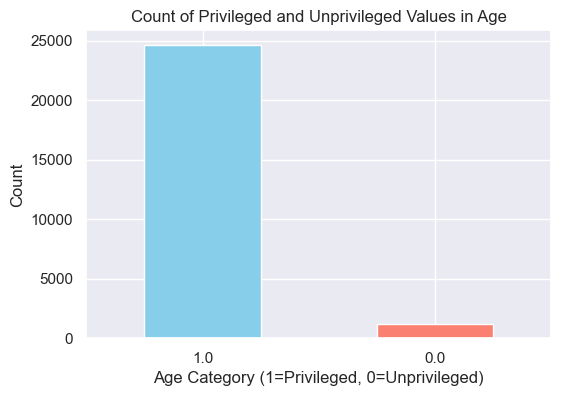

In [72]:
# Count the occurrences of privileged and unprivileged values
age_counts = df_bank['age'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Age')
plt.xlabel('Age Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [77]:
y_counts = df_bank['y'].value_counts()

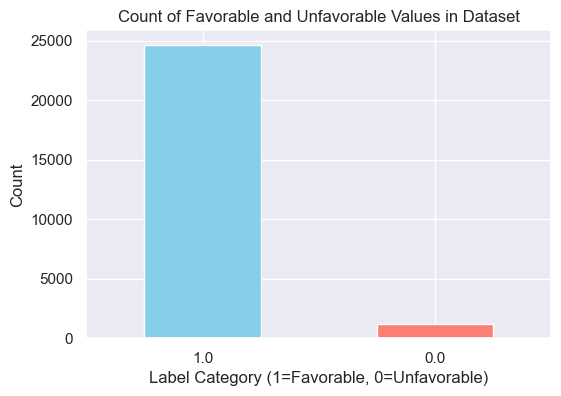

In [78]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['y'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [76]:
df_bank.shape

(25836, 58)

## Display Output

In [22]:
priv_metric_orig_copy = priv_metric_orig

In [23]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 36962.0, 'total_unpriv': 1792.0})

In [24]:
priv_metric_orig

defaultdict(float, {'total_priv': 36962.0, 'total_unpriv': 1792.0})

In [25]:
priv_metric_orig = priv_metric_orig_copy

1)

bank
12918
2)

                total_priv  total_unpriv
num_instance                            
orig          12320.666667    597.333333
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.099835       0.900165    0.092663      0.907337      0.247749   
transf      0.092663       0.907337    0.092663      0.907337      0.092663   

         unpriv_unfavor  
dataset                  
orig           0.752251  
transf         0.907337  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.827958       0.091444  0.554107       0.249374   
dt_syn                     0.693296      -0.107022  0.265936       0.031870   
dt_dir                     0.817342       0.079447  0.582086       0.266999   
dt_rew                     0.82269

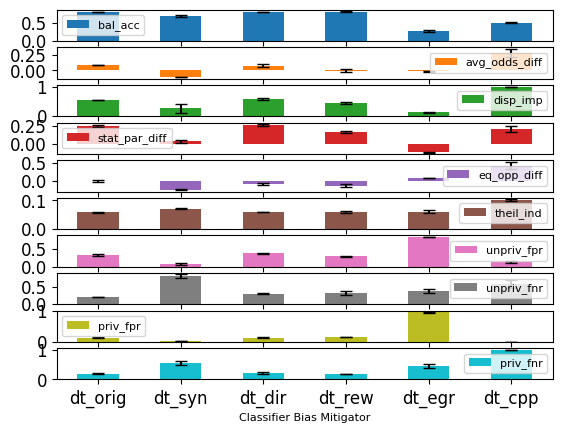

In [26]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

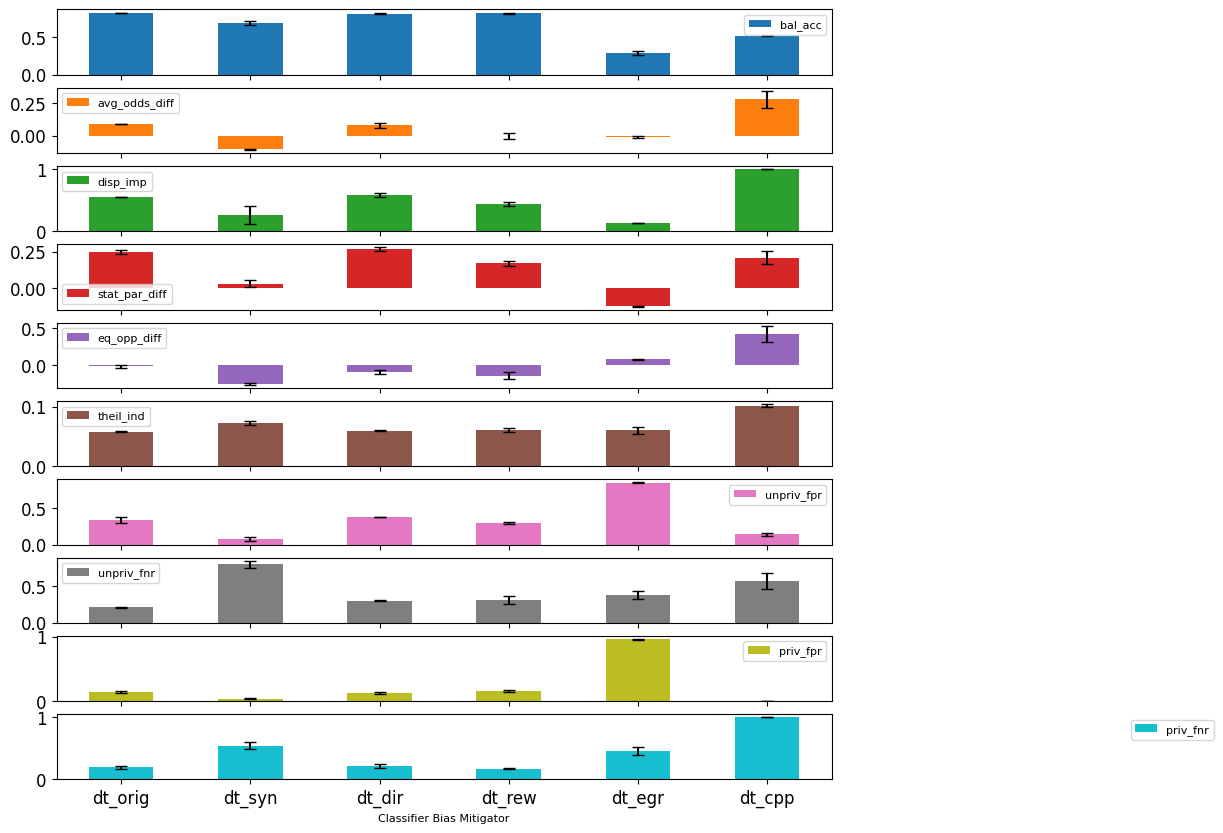

In [27]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [28]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.827958,0.091444,0.554107,0.249374,-0.015618,0.057948,0.338058,0.210776,0.139552,0.195158
dt_syn,0.693296,-0.107022,0.265936,0.031870,-0.253360,0.071796,0.076610,0.798924,0.037295,0.545564
dt_dir,0.817342,0.079447,0.582086,0.266999,-0.089715,0.059716,0.380168,0.303719,0.131559,0.214004
dt_rew,0.822693,-0.002002,0.435403,0.171084,-0.138922,0.060315,0.295257,0.312104,0.160340,0.173182
dt_egr,0.295994,-0.011271,0.133774,-0.123088,0.080110,0.060617,0.856496,0.381846,0.959148,0.461957
dt_cpp,0.521696,0.283137,1.000000,0.211251,0.425760,0.101239,0.140514,0.574240,0.000000,1.000000


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [29]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [30]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.523778,0.513847,0.617543,0.560483,0.659767,0.512308,0.613107
syn,0.516166,0.508944,0.583999,0.543323,0.609125,0.507946,0.583612
dir,0.529016,0.521506,0.616564,0.590785,0.693765,0.519345,0.608316
rew,0.522798,0.512870,0.614638,0.557628,0.645073,0.511111,0.613582
egr,0.526075,0.516609,0.618561,0.584119,0.697314,0.513940,0.618396


In [31]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [32]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [33]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.560483,0.659767,0.512308,0.613107
syn,0.543323,0.609125,0.507946,0.583612
dir,0.590785,0.693765,0.519345,0.608316
rew,0.557628,0.645073,0.511111,0.613582
egr,0.584119,0.697314,0.513940,0.618396


<Axes: xlabel='Classifier MIA Attacks'>

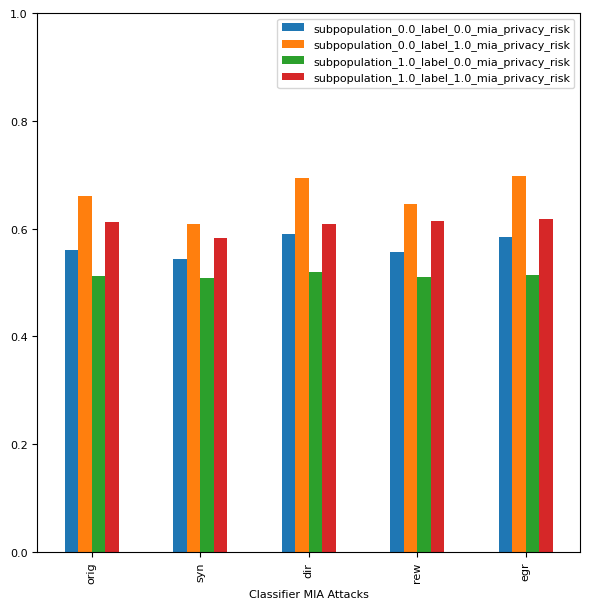

In [34]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [35]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.560483  0.543323  0.590785  0.557628  0.584119
subpopulation_0.0_label_1.0_mia_privacy_risk  0.659767  0.609125  0.693765  0.645073  0.697314
subpopulation_1.0_label_0.0_mia_privacy_risk  0.512308  0.507946  0.519345  0.511111  0.51394
subpopulation_1.0_label_1.0_mia_privacy_risk  0.613107  0.583612  0.608316  0.613582  0.618396


### Visualizing using novel technique

In [36]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [37]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [38]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.523727
1,orig,entire_dataset_mia_privacy_risk,0.523804
2,orig,entire_dataset_mia_privacy_risk,0.523804
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.515366
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.513088
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.512813
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.512813
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.609861
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.622663


In [39]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.523727
1,orig,entire_dataset_mia_privacy_risk,0.523804
2,orig,entire_dataset_mia_privacy_risk,0.523804
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.554545
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.563452
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.512813
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.512813
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.609861
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.622663


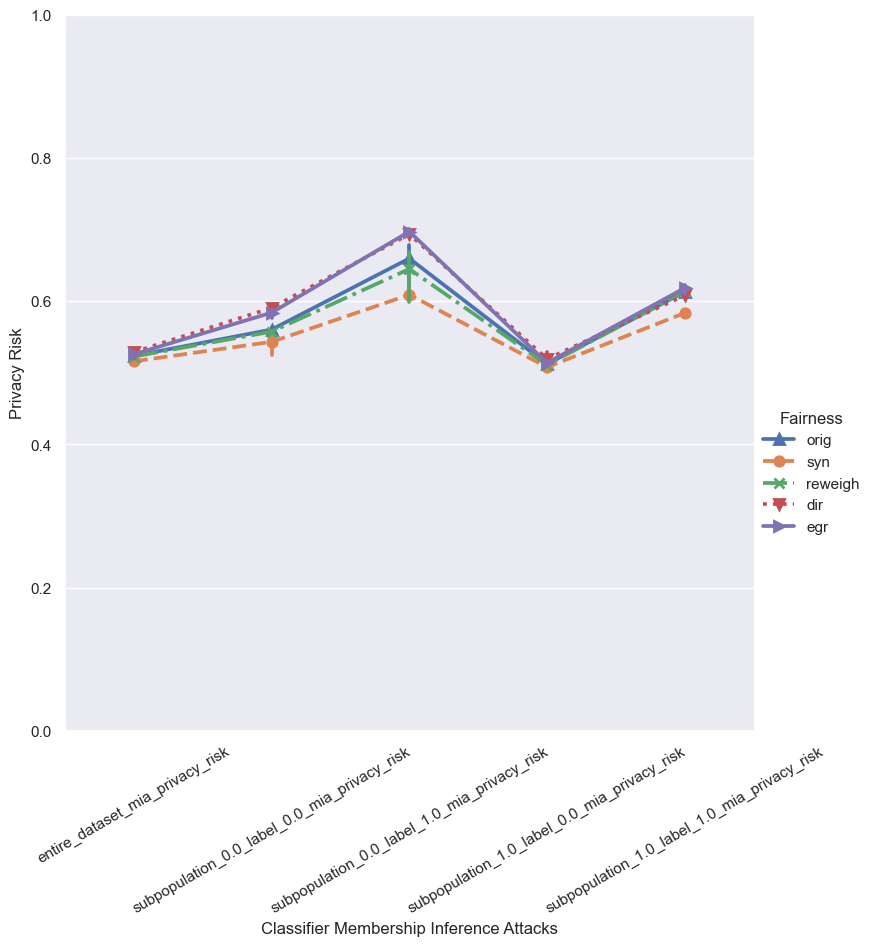

In [40]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [41]:
from sklearn.metrics import RocCurveDisplay, auc

In [42]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

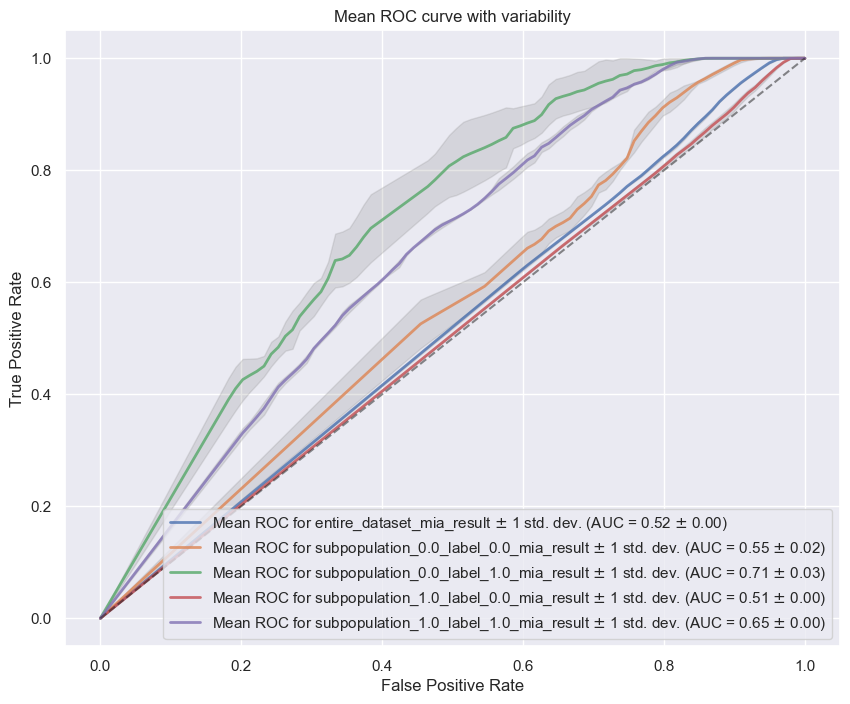

In [43]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

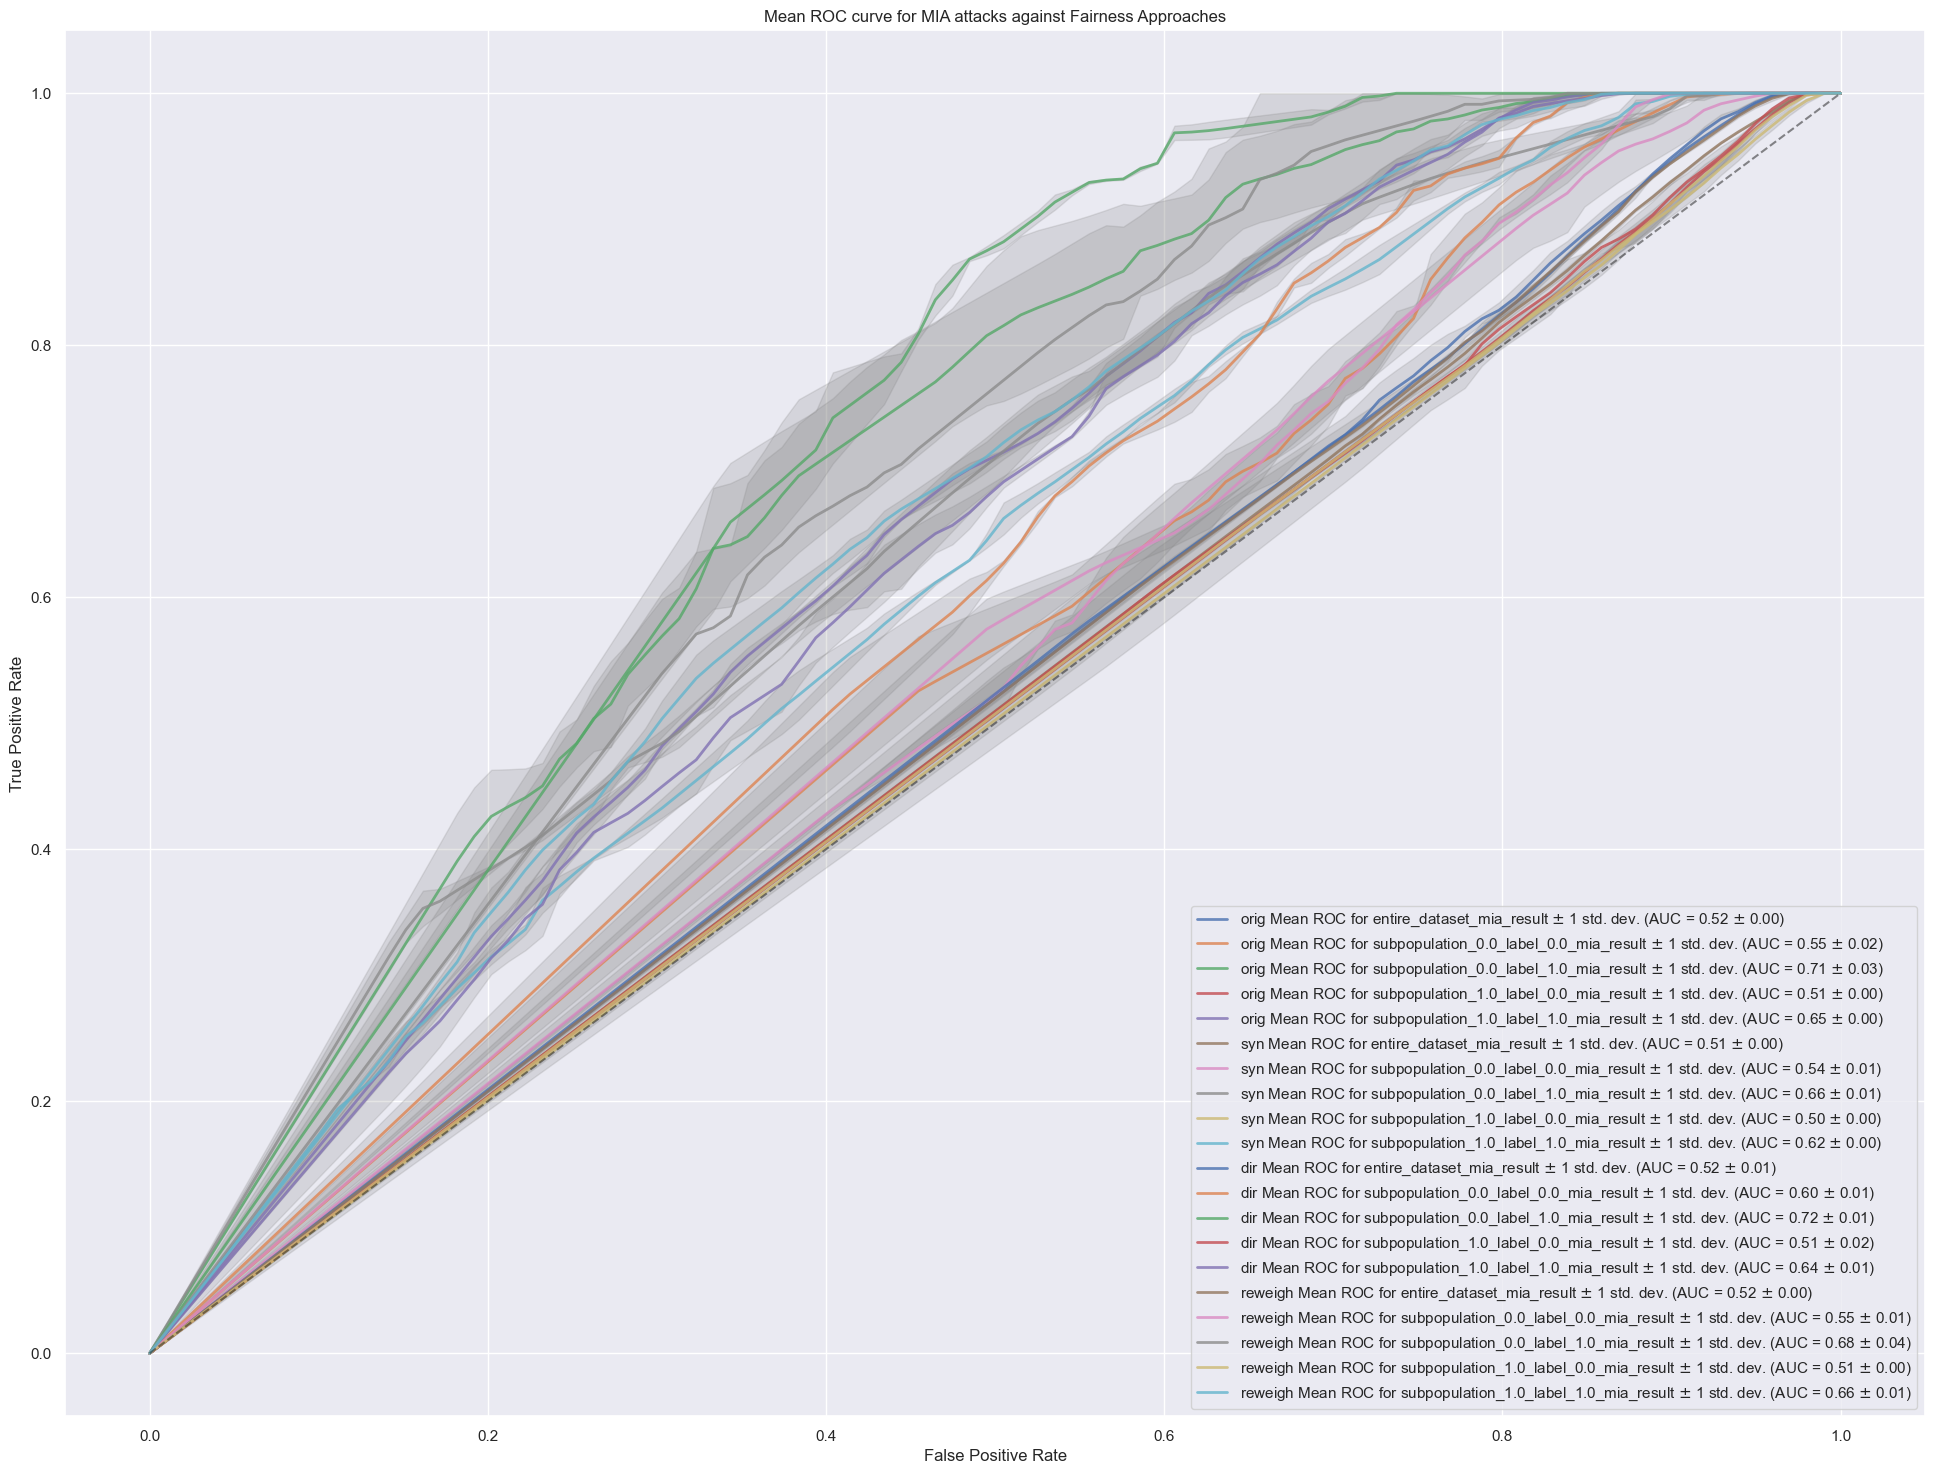

In [44]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

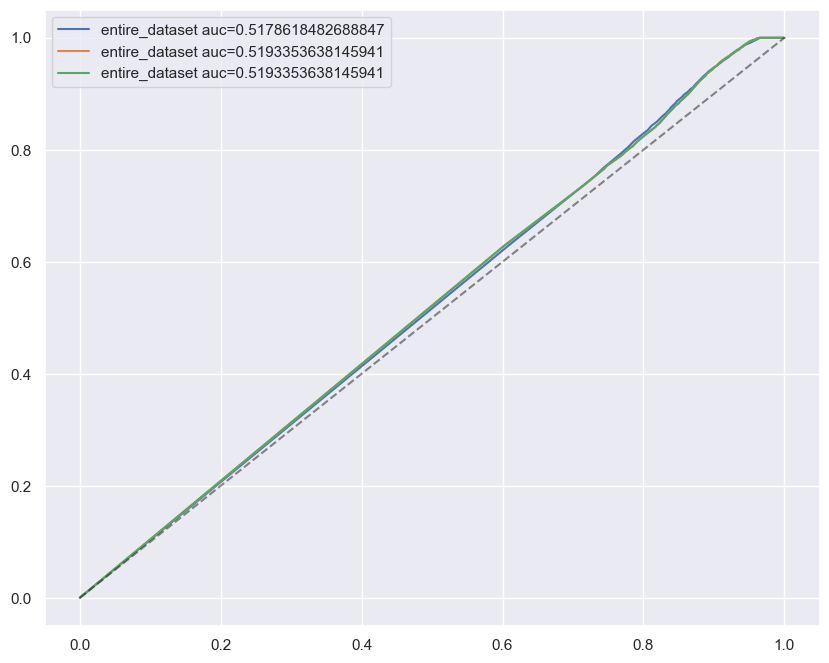

In [45]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [46]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("mia_auc")}

In [47]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5188441919660243,
 'entire_dataset_label_0.0_mia_auc': 0.5085208888769097,
 'entire_dataset_label_1.0_mia_auc': 0.6568634124116118,
 'subpopulation_0.0_label_0.0_mia_auc': 0.5535276254701916,
 'subpopulation_0.0_label_1.0_mia_auc': 0.7054254646600034,
 'subpopulation_1.0_label_0.0_mia_auc': 0.5069568187953181,
 'subpopulation_1.0_label_1.0_mia_auc': 0.6502565700203811}

In [48]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.518844,0.508521,0.656863,0.553528,0.705425,0.506957,0.650257
syn,0.511026,0.504313,0.620263,0.539188,0.656623,0.503353,0.615731
dir,0.520975,0.512005,0.649037,0.597487,0.721747,0.508739,0.636389
rew,0.518227,0.508542,0.658874,0.554902,0.683004,0.506828,0.656366
egr,0.526851,0.516793,0.642343,0.585276,0.718425,0.514109,0.635708


<Axes: xlabel='Classifier MIA Attacks'>

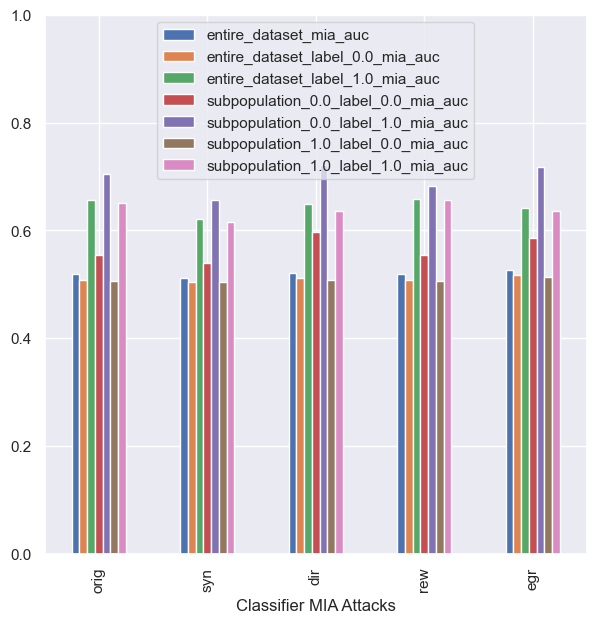

In [49]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [50]:
# Creating data structures to plot point categorical plot from seaborn

In [51]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [52]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.047453166124787116,
  0.047607988852763516,
  0.047607988852763516],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.030731105850359097,
  0.026176855068540394,
  0.026176855068540394],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.2328938174360463,
  0.2361815669568214,
  0.2361815669568214],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.10908954100827695,
  0.12690362968759406,
  0.12690362968759406],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.2445252116304748,
  0.3570377861542705,
  0.3570377861542705],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.02801419571730357,
  0.022915458315240667,
  0.022915458315240667],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.23268924699478688,
  0.22297600696228614,
  0.22297600696228614]}

In [53]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.047453166124787116],
 ['orig', 'entire_dataset', 0.047607988852763516],
 ['orig', 'entire_dataset', 0.047607988852763516],
 ['orig', 'entire_dataset_label_0.0', 0.030731105850359097],
 ['orig', 'entire_dataset_label_0.0', 0.026176855068540394],
 ['orig', 'entire_dataset_label_0.0', 0.026176855068540394],
 ['orig', 'entire_dataset_label_1.0', 0.2328938174360463],
 ['orig', 'entire_dataset_label_1.0', 0.2361815669568214],
 ['orig', 'entire_dataset_label_1.0', 0.2361815669568214],
 ['orig', 'subpopulation_0.0_label_0.0', 0.10908954100827695],
 ['orig', 'subpopulation_0.0_label_0.0', 0.12690362968759406],
 ['orig', 'subpopulation_0.0_label_0.0', 0.12690362968759406],
 ['orig', 'subpopulation_0.0_label_1.0', 0.2445252116304748],
 ['orig', 'subpopulation_0.0_label_1.0', 0.3570377861542705],
 ['orig', 'subpopulation_0.0_label_1.0', 0.3570377861542705],
 ['orig', 'subpopulation_1.0_label_0.0', 0.02801419571730357],
 ['orig', 'subpopulation_1.0_label_0.0', 0.022915

In [54]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.047453
1,orig,entire_dataset,0.047608
2,orig,entire_dataset,0.047608
3,orig,entire_dataset_label_0.0,0.030731
4,orig,entire_dataset_label_0.0,0.026177
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.025625
101,egr,subpopulation_1.0_label_0.0,0.025625
102,egr,subpopulation_1.0_label_1.0,0.219723
103,egr,subpopulation_1.0_label_1.0,0.245326


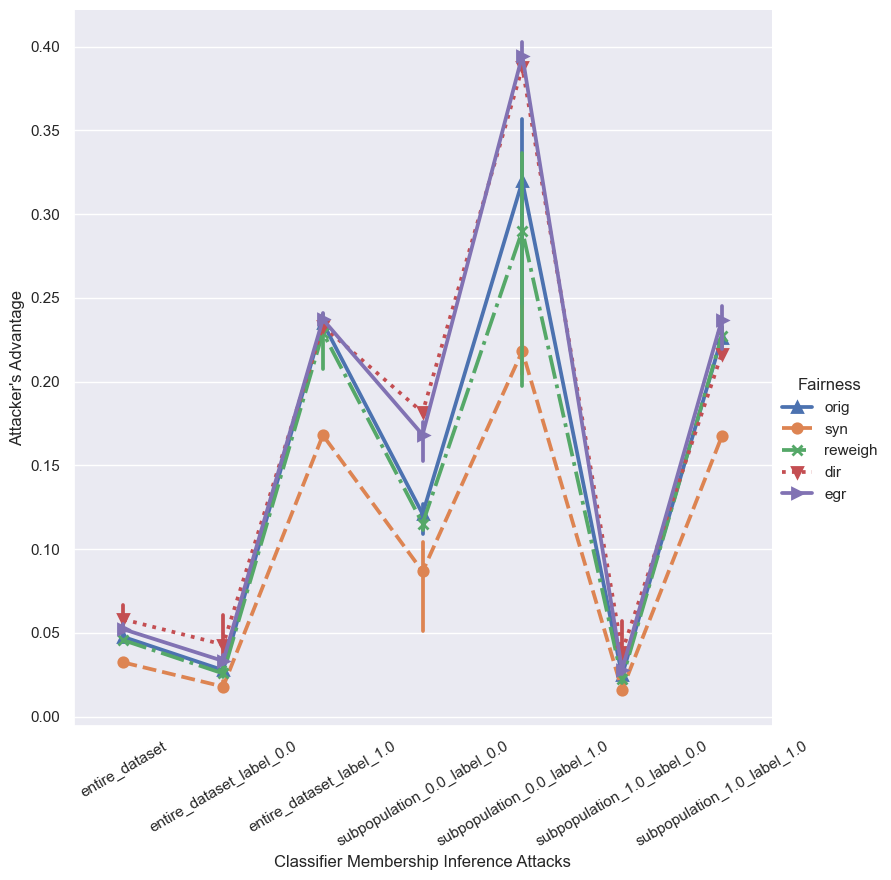

In [55]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


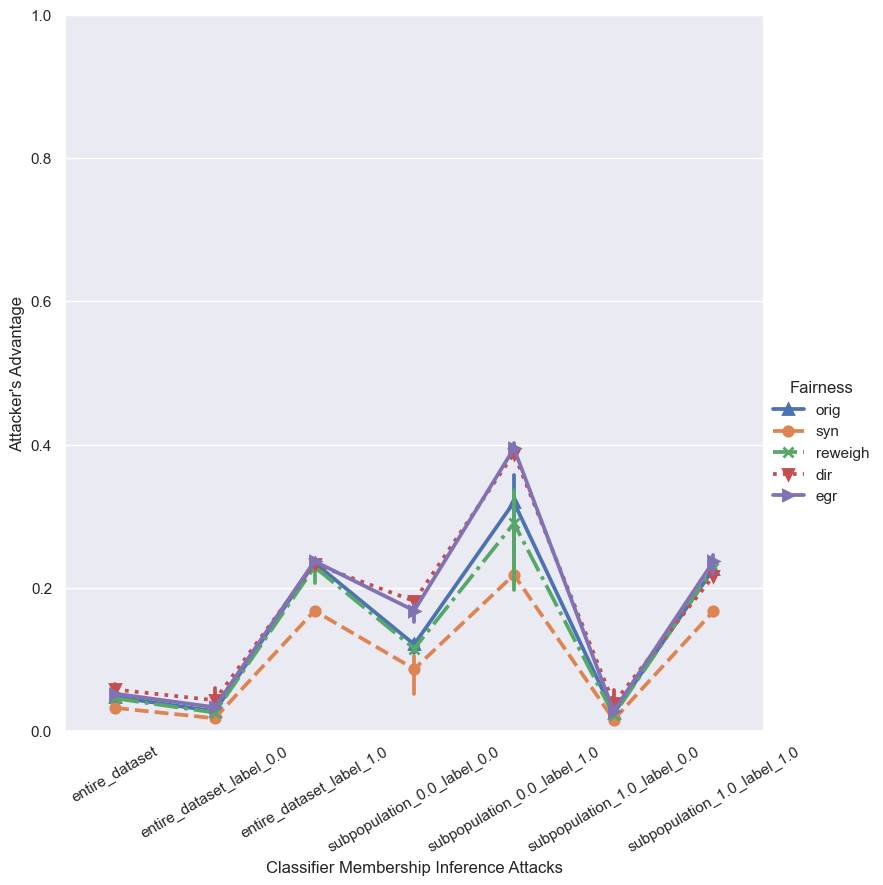

In [56]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [57]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.047453,0.030731,0.232894,0.109090,0.244525,0.028014,0.232689
1,0.047608,0.026177,0.236182,0.126904,0.357038,0.022915,0.222976
2,0.047608,0.026177,0.236182,0.126904,0.357038,0.022915,0.222976


In [58]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [59]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.047556381276771385,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.027694938662479962,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.23508565044989638,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.12096560012782169,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.3195335946463386,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.024615037449261634,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.22621375363978638}

In [60]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.047556,0.027695,0.235086,0.120966,0.319534,0.024615,0.226214
syn,0.032332,0.017888,0.167997,0.086646,0.218250,0.015892,0.167223
dir,0.058033,0.043012,0.233128,0.181570,0.387530,0.038691,0.216633
rew,0.045595,0.025740,0.229276,0.115256,0.290147,0.022221,0.227165
egr,0.052149,0.033217,0.237121,0.168238,0.394628,0.027880,0.236791


<Axes: xlabel='Classifier MIA Attacks'>

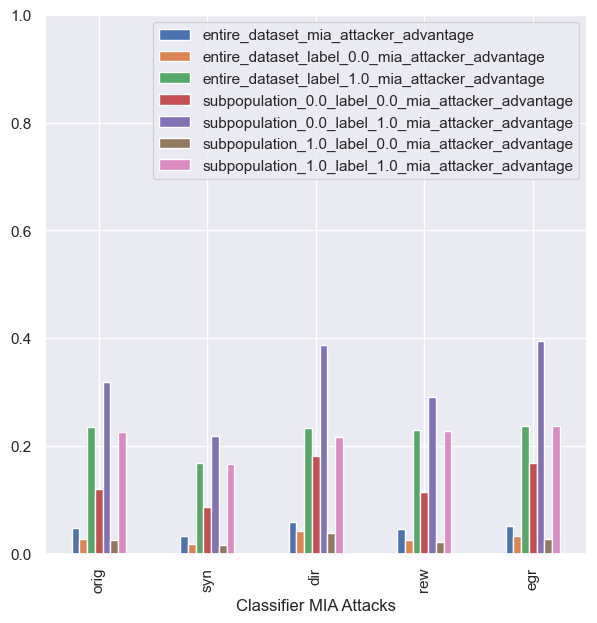

In [61]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [62]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("mia_ppv")}

In [63]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.512953805840835],
 ['orig', 'entire_dataset', 0.5127260687828498],
 ['orig', 'entire_dataset', 0.5127260687828498],
 ['orig', 'entire_dataset_label_0.0', 0.5067877371212802],
 ['orig', 'entire_dataset_label_0.0', 0.5071218730526128],
 ['orig', 'entire_dataset_label_0.0', 0.5071218730526128],
 ['orig', 'entire_dataset_label_1.0', 0.6284090909090909],
 ['orig', 'entire_dataset_label_1.0', 0.6311360448807853],
 ['orig', 'entire_dataset_label_1.0', 0.6311360448807853],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5342465753424658],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5530973451327434],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5530973451327434],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6629213483146067],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6923076923076923],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6923076923076923],
 ['orig', 'subpopulation_1.0_label_0.0', 0.5058531560217269],
 ['orig', 'subpopulation_1.0_label_0.0', 0.5061643521701269],
 ['o

In [64]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.512954
1,orig,entire_dataset,0.512726
2,orig,entire_dataset,0.512726
3,orig,entire_dataset_label_0.0,0.506788
4,orig,entire_dataset_label_0.0,0.507122
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.507025
101,egr,subpopulation_1.0_label_0.0,0.507025
102,egr,subpopulation_1.0_label_1.0,0.627929
103,egr,subpopulation_1.0_label_1.0,0.642932


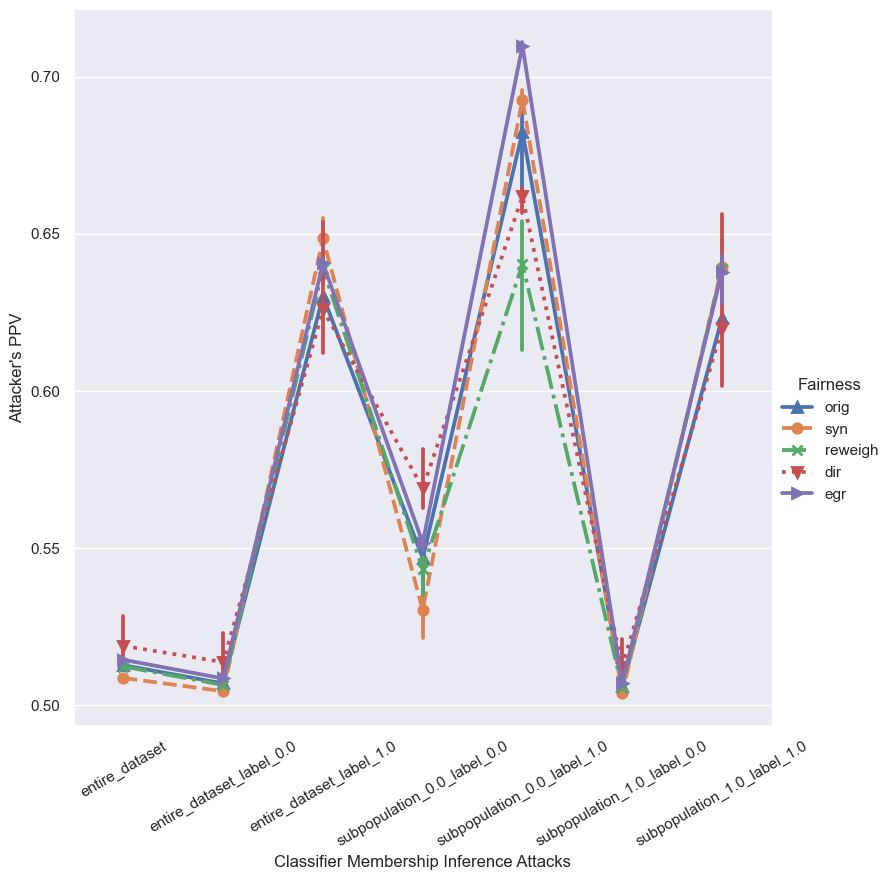

In [65]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [66]:
import pandas as pd

In [67]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25831,1.0,281.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25832,0.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25833,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25834,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [68]:
df[["age", "labels"]].value_counts(normalize=True)

age  labels
1.0  0.0       0.865885
1.0  1.0       0.088133
0.0  0.0       0.034564
0.0  1.0       0.011418
Name: proportion, dtype: float64

In [69]:
df.drop_duplicates()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25831,1.0,281.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25832,0.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25833,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25834,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## DT Accuracy

In [70]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER)

[INFO]: training decision tree
Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       449
         1.0       0.00      0.00      0.00         0

    accuracy                           0.97       449
   macro avg       0.50      0.48      0.49       449
weighted avg       1.00      0.97      0.98       449

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.73      0.84       146

    accuracy                           0.73       146
   macro avg       0.50      0.36      0.42       146
weighted avg       1.00      0.73      0.84       146

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     11192
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99     1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'train_0_0': 0.9665924276169265,
 'train_0_1': 0.726027397260274,
 'train_1_0': 0.98668691922802,
 'train_1_1': 0.6419098143236074,
 'test_0_0': 0.8671171171171171,
 'test_0_1': 0.3624161073825503,
 'test_1_0': 0.9638608104481617,
 'test_1_1': 0.43019197207678883}

In [71]:
train_test_egr

{'train_0_0': 0.9732739420935412,
 'train_0_1': 0.6712328767123288,
 'train_1_0': 0.983470335954253,
 'train_1_1': 0.6613616268788682,
 'test_0_0': 0.8648648648648649,
 'test_0_1': 0.3221476510067114,
 'test_1_0': 0.9617139279005278,
 'test_1_1': 0.4493891797556719}